In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd

In [105]:
import time

In [2]:
inpath = r'T:\Public Transportation\Transit Development Plan 2022-2023\Outreach 1 Mapping Survey Responses'

In [69]:
df = pd.read_csv(inpath+'\\route.csv')

In [93]:
df.head()

,Route,Counts,Origin,Destination,OLongitude,OLatitude,DLongitude,DLatitude
0,Florence-Eugene,22,Florence,Eugene,-124.109310,44.000263,-123.124135,44.063539
1,Oakridge-Eugene,12,Oakridge,Eugene,-122.453342,43.745711,-123.124135,44.063539
2,Oakridge-Springfield,8,Oakridge,Springfield,-122.453342,43.745711,-123.007180,44.049242
3,Florence-Springfield,7,Florence,Springfield,-124.109310,44.000263,-123.007180,44.049242
4,Veneta-Eugene,5,Veneta,Eugene,-123.351318,44.047139,-123.124135,44.063539


In [112]:
df.shape

(80, 8)

In [8]:
ndf=df[~df["Route"].str.contains("Coos Bay|Reedsport|Yachats|Canon Beach|Camp Creek")]

In [111]:
ndf=ndf.copy()[ndf.Origin != ndf.Destination]

In [113]:
ndf.shape

(71, 8)

In [4]:
G= ox.graph_from_place('Lane County, Oregon, USA')

In [109]:
def get_shortest_route(orgnm, olon, olat, dstnm, dlon, dlat):
    routenm = orgnm+'-'+dstnm
    print(routenm)
    origin = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
    origin.at[0, 'geometry'] = Point(olon, olat)
    origin.at[0, 'name'] = orgnm
    destination = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
    destination.at[0, 'geometry'] = Point(dlon, dlat)
    destination.at[0, 'name'] = dstnm
    
    origin_node_id = ox.nearest_nodes(G, origin.geometry.x, origin.geometry.y)
    destination_node_id = ox.nearest_nodes(G, destination.geometry.x, destination.geometry.y)
    
    route = ox.shortest_path(G, origin_node_id, destination_node_id)
    nodes, edges = ox.graph_to_gdfs(G)
    route_nodes = nodes.loc[route[0]]
    
    route_line = shapely.geometry.LineString(list(route_nodes.geometry.values))
    route_geom = gpd.GeoDataFrame({
        "geometry": [route_line],
        "osm_nodes": [route[0]],
    })
    gdf=route_geom.set_crs(edges.crs, allow_override=True)
    
    gdf=gdf.to_crs(epsg=2914)
    gdf["length_km"] = gdf.length*0.3048/1000
    gdf["start"] = orgnm
    gdf["end"] = dstnm
    gdf["route"] = routenm
    
    return route[0], route_line, gdf

In [90]:
route, route_line, gdf = get_shortest_route(orgnm = 'Florence', 
                                            olon = -124.109310,
                                            olat = 44.000263,
                                            dstnm = 'Eugene',
                                            dlon = -123.124135,
                                            dlat = 44.063539
                                            )

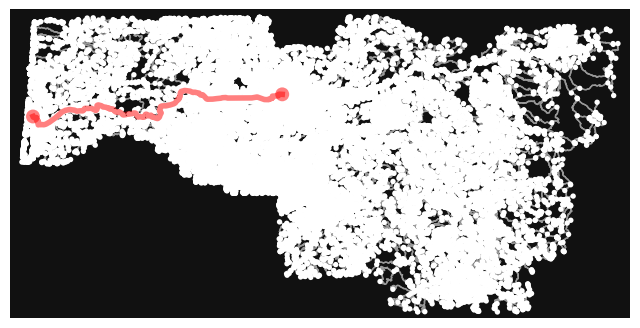

In [86]:
fig, ax = ox.plot_graph_route(G, route)B

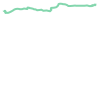

In [87]:
route_line

In [91]:
gdf

,geometry,osm_nodes,length_km,start,end,route
0,"LINESTRING (3970733.225 870896.819, 3970729.14...","[40143113, 40143112, 40261681, 40102756, 40021...",94.850054,Florence,Eugene,Florence-Eugene


In [100]:
df.columns

Index(['Route', 'Counts', 'Origin', 'Destination', 'OLongitude', 'OLatitude',
       'DLongitude', 'DLatitude'],
      dtype='object')

In [114]:
t0 = time.time()
out = list(ndf.apply(lambda row: get_shortest_route(row.Origin, row.OLongitude, row.OLatitude, row.Destination, row.DLongitude, row.DLatitude)[2], axis=1))
elapsed = (time.time() - t0) / 60
print('Elapsed time: %.2fminutes' % (elapsed))

Florence-Eugene
Oakridge-Eugene
Oakridge-Springfield
Florence-Springfield
Veneta-Eugene
Eugene-Florence
Blue River-Eugene
Florence-Eugene Airport
Mapleton-Eugene
Vida-Eugene
Springfield-Florence
Florence-Riverbend Hospital
Oakridge-Willamalane Swim Center
Veneta-Mapleton
Cedar Flat-Costco Wholesale, Eugene
Washington Street Apartments-Oregon Horse Center
Cal Young-Downtown Eugene
Downtown Eugene-Oregon Horse Center
Thurston Station Park And Ride-Blue River
Florence-Schnitzer Museum
Oakridge-Oregon Coast
Vida-Springfield
Eugene-Richardson Park
West Eugene-Springfield
Florence-WinCo Foods, Springfield
Lorane Highway-Eugene
Eugene-Salmon Creek Falls
Creswell-Springfield
Walton-Florence
Eugene-Coburg
Florence-Costco Wholesale, Eugene
Florence-Valley River Center
Oakridge-Sheldon Pool & Fitness Center
Cheshire-Florence
Oakridge-Danebo
Eugene-Mckenzie Bridge
Alvadore-Eugene
Eugene-Oregon Coast
Florence-Hult Center
Junction City-Springfield
E 24th Ave & Willamette St, Eugene-E 22nd Ave & Onyx

In [115]:
outgdf = pd.concat(out, ignore_index=True)

In [118]:
outgdf.head()

,geometry,osm_nodes,length_km,start,end,route
0,"LINESTRING (3970733.225 870896.819, 3970729.14...","[40143113, 40143112, 40261681, 40102756, 40021...",94.850054,Florence,Eugene,Florence-Eugene
1,"LINESTRING (4405114.214 763635.703, 4404664.12...","[40011840, 40011834, 40005202, 40005184, 40121...",68.912662,Oakridge,Eugene,Oakridge-Eugene
2,"LINESTRING (4405114.214 763635.703, 4404664.12...","[40011840, 40011834, 40005202, 40005184, 40121...",61.519237,Oakridge,Springfield,Oakridge-Springfield
3,"LINESTRING (3970733.225 870896.819, 3970729.14...","[40143113, 40143112, 40261681, 40102756, 40021...",103.150226,Florence,Springfield,Florence-Springfield
4,"LINESTRING (4171702.478 880327.934, 4171603.02...","[6397609631, 6397609630, 6397608959, 639760963...",20.512621,Veneta,Eugene,Veneta-Eugene


In [120]:
sdf=df[['Route', 'Counts']].rename(columns={'Route':'route', 'Counts':'counts'})

In [122]:
outgdf = outgdf[['route', 'start', 'end', 'length_km', 'geometry']].merge(sdf, on='route')

In [123]:
outgdf.to_file(inpath+'\\routes.shp')

In [125]:
outgdf.head(10)

,route,start,end,length_km,geometry,counts
0,Florence-Eugene,Florence,Eugene,94.850054,"LINESTRING (3970733.225 870896.819, 3970729.14...",22
1,Oakridge-Eugene,Oakridge,Eugene,68.912662,"LINESTRING (4405114.214 763635.703, 4404664.12...",12
2,Oakridge-Springfield,Oakridge,Springfield,61.519237,"LINESTRING (4405114.214 763635.703, 4404664.12...",8
3,Florence-Springfield,Florence,Springfield,103.150226,"LINESTRING (3970733.225 870896.819, 3970729.14...",7
4,Veneta-Eugene,Veneta,Eugene,20.512621,"LINESTRING (4171702.478 880327.934, 4171603.02...",5
5,Eugene-Florence,Eugene,Florence,94.875114,"LINESTRING (4231591.114 884296.980, 4231520.29...",5
6,Blue River-Eugene,Blue River,Eugene,83.800486,"LINESTRING (4476412.557 917626.404, 4472958.20...",3
7,Florence-Eugene Airport,Florence,Eugene Airport,91.871132,"LINESTRING (3970733.225 870896.819, 3970729.14...",3
8,Mapleton-Eugene,Mapleton,Eugene,68.838957,"LINESTRING (4037930.194 879496.930, 4038082.05...",2
9,Vida-Eugene,Vida,Eugene,48.668761,"LINESTRING (4377102.420 910721.032, 4376948.64...",2
